#### CNN SAT-6
CNN example for SAT-6 dataset

In [1]:
import numpy as np
import scipy.io as sio
from scipy.io import loadmat
# http://stackoverflow.com/a/12591639
# load SAT-6 dataset
matfile = loadmat('/home/cdathuraliya/work/lirneasia/land-use/SAT-4_SAT-6/SAT-4_and_SAT-6_datasets/sat-6-full.mat', squeeze_me=True, struct_as_record=False)

In [2]:
# read image and reshape from 28x28x4 to 1x3136
# convert pixel intensities from 0-255 to 0-1 and change data type
train_images_u8 = matfile.get('train_x').reshape(324000, -1)
train_images = np.float32([x / 255.0 for x in train_images_u8])
del train_images_u8 # release highly used memory
print train_images.shape

train_labels_u8 = matfile.get('train_y')
train_labels = np.transpose(np.float32(train_labels_u8))
del train_labels_u8
print train_labels.shape

test_images_u8 = matfile.get('test_x').reshape(81000, -1)
test_images = np.float32([x / 255.0 for x in test_images_u8])
del test_images_u8
print test_images.shape

test_labels_u8 = matfile.get('test_y')
test_labels = np.transpose(np.float32(test_labels_u8))
del test_labels_u8
print test_labels.shape

del matfile

(324000, 3136)
(324000, 6)
(81000, 3136)
(81000, 6)


In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 3136])
y_ = tf.placeholder(tf.float32, shape=[None, 6])

# Weight Initialization
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

#Convolution and Pooling
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 4, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,4])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely Connected Layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout Layer
W_fc2 = weight_variable([1024, 6])
b_fc2 = bias_variable([6])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Train and Evaluate
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

In [4]:
import time
start_time = time.time()

for i in range(20000):
   # select a random minibatch (SAT-6 sample size: 324000, batch size: 100)
  indices = np.random.choice(60000, 100)
  batch_xs, batch_ys = train_images[indices], train_labels[indices]
  if i%500 == 0:
    train_accuracy = accuracy.eval(feed_dict={
      x:batch_xs, y_: batch_ys, keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
    
end_time = time.time()

step 0, training accuracy 0.38
step 500, training accuracy 0.4
step 1000, training accuracy 0.48
step 1500, training accuracy 0.49
step 2000, training accuracy 0.43
step 2500, training accuracy 0.4
step 3000, training accuracy 0.39
step 3500, training accuracy 0.41
step 4000, training accuracy 0.34
step 4500, training accuracy 0.43
step 5000, training accuracy 0.31
step 5500, training accuracy 0.39
step 6000, training accuracy 0.36
step 6500, training accuracy 0.3
step 7000, training accuracy 0.41
step 7500, training accuracy 0.33
step 8000, training accuracy 0.35
step 8500, training accuracy 0.43
step 9000, training accuracy 0.32
step 9500, training accuracy 0.42
step 10000, training accuracy 0.39
step 10500, training accuracy 0.45
step 11000, training accuracy 0.41
step 11500, training accuracy 0.35
step 12000, training accuracy 0.41
step 12500, training accuracy 0.49
step 13000, training accuracy 0.46
step 13500, training accuracy 0.47
step 14000, training accuracy 0.55
step 14500, 

In [5]:
del train_images
del train_labels

In [6]:
# select a random minibatch (SAT-6 sample size: 81000, batch size: 2000)
test_indices = np.random.choice(81000, 2000)
test_batch_xs, test_batch_ys = test_images[test_indices], test_labels[test_indices]

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: test_batch_xs, y_: test_batch_ys, keep_prob: 1.0}))

training_time = end_time - start_time
print "Training time (seconds): ",training_time

test accuracy 0.3205
Training time (seconds):  317.592185974


#### Visualizing Neural Network Layer Activation
https://medium.com/@awjuliani/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4#.ksc8aztu9

In [7]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,3136],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest")

[ 0.  0.  1.  0.  0.  0.]


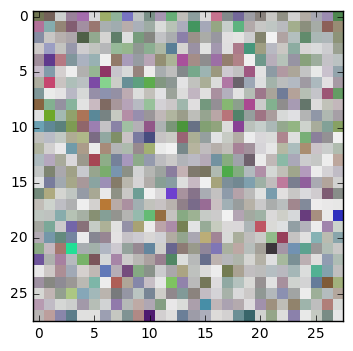

In [8]:
import numpy as np
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt

imageToUse = test_images[0]
print test_labels[0]
# http://stackoverflow.com/a/25626042
plt.imshow(np.reshape(imageToUse,[28,28,4]), interpolation="nearest")

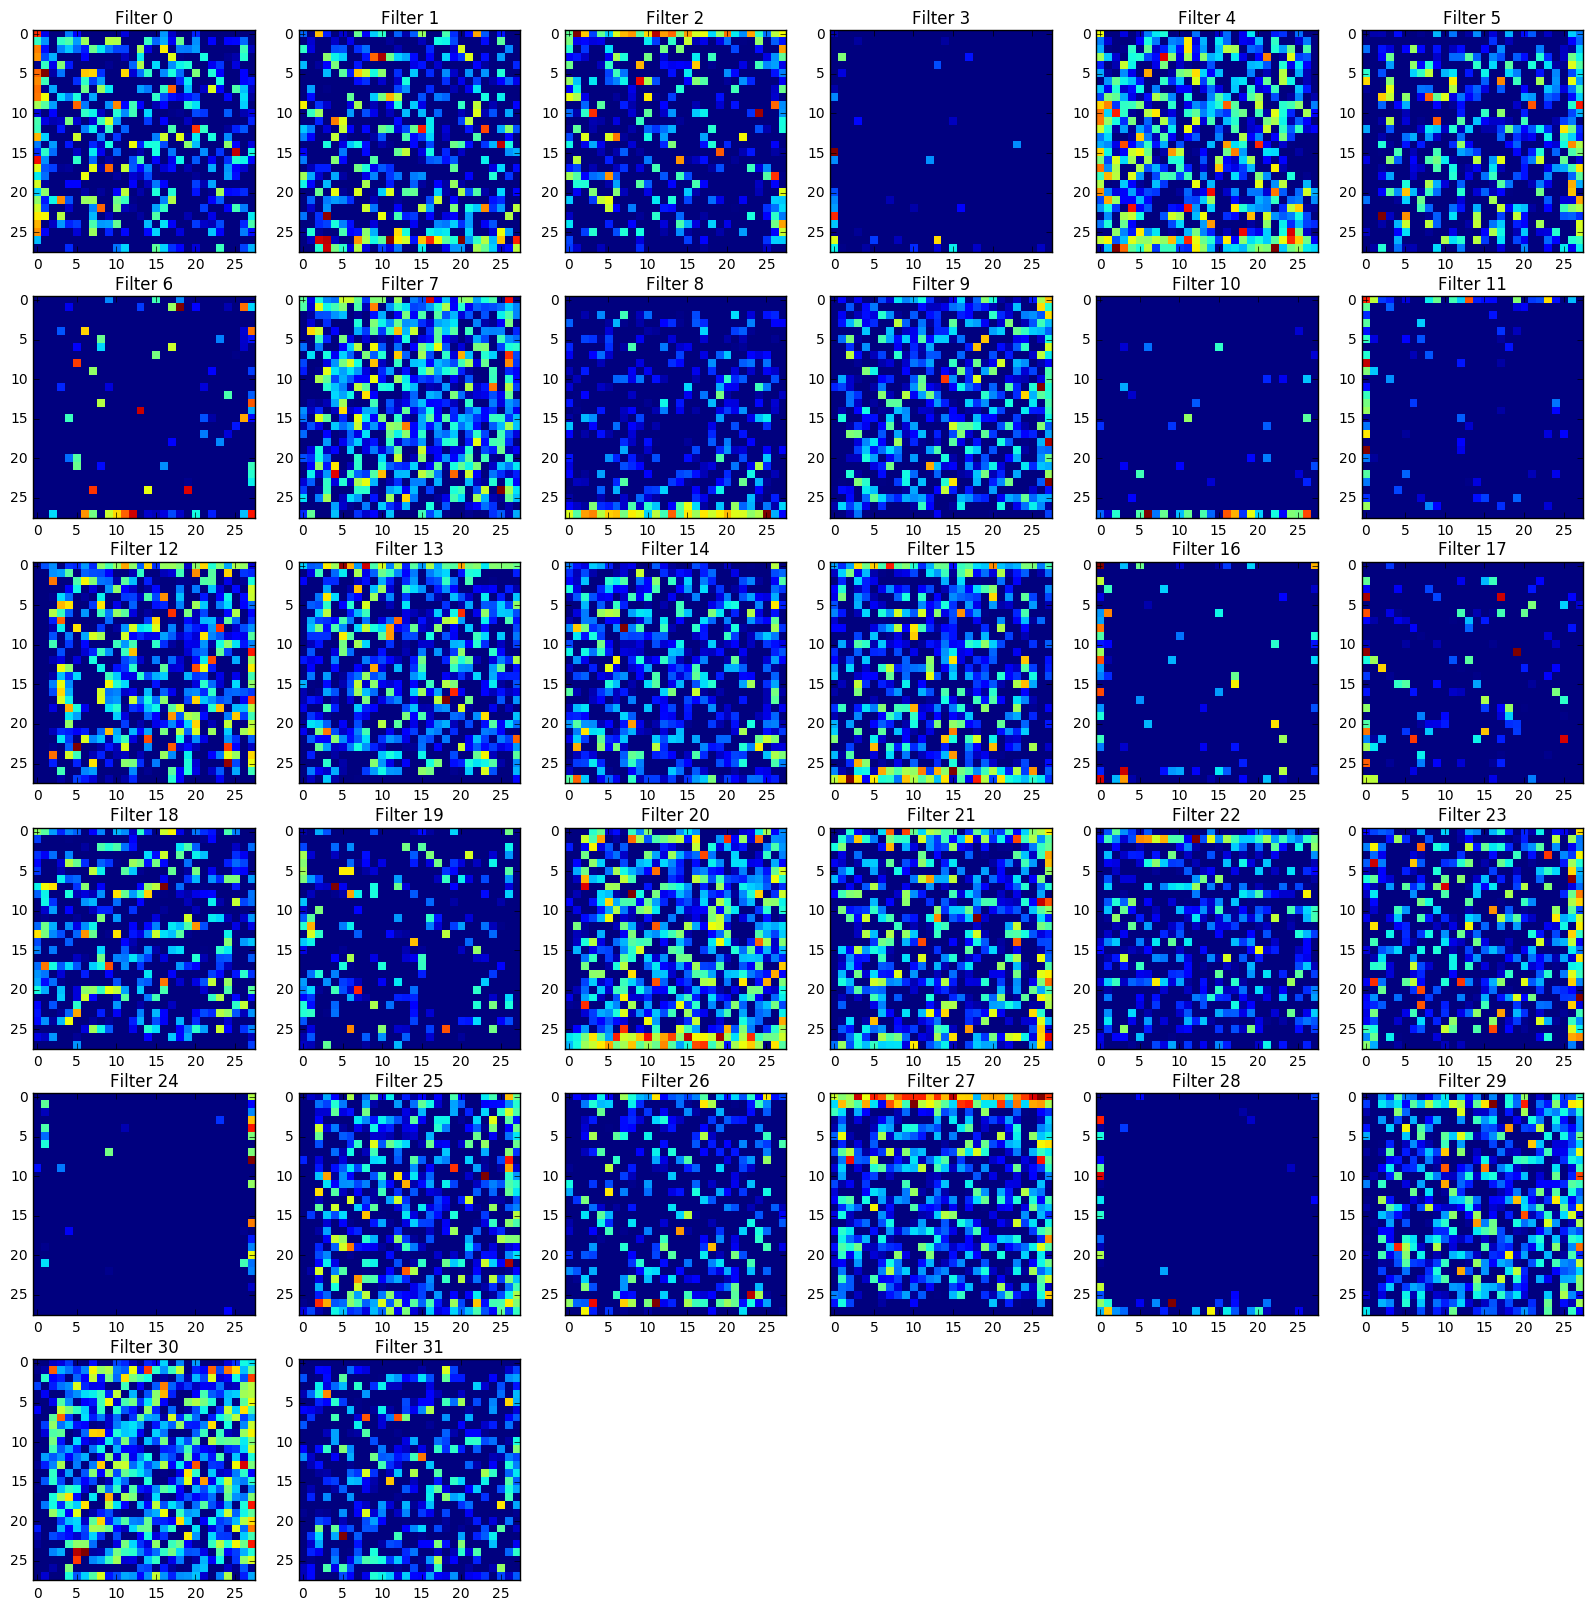

In [9]:
import math

getActivations(h_conv1,imageToUse)

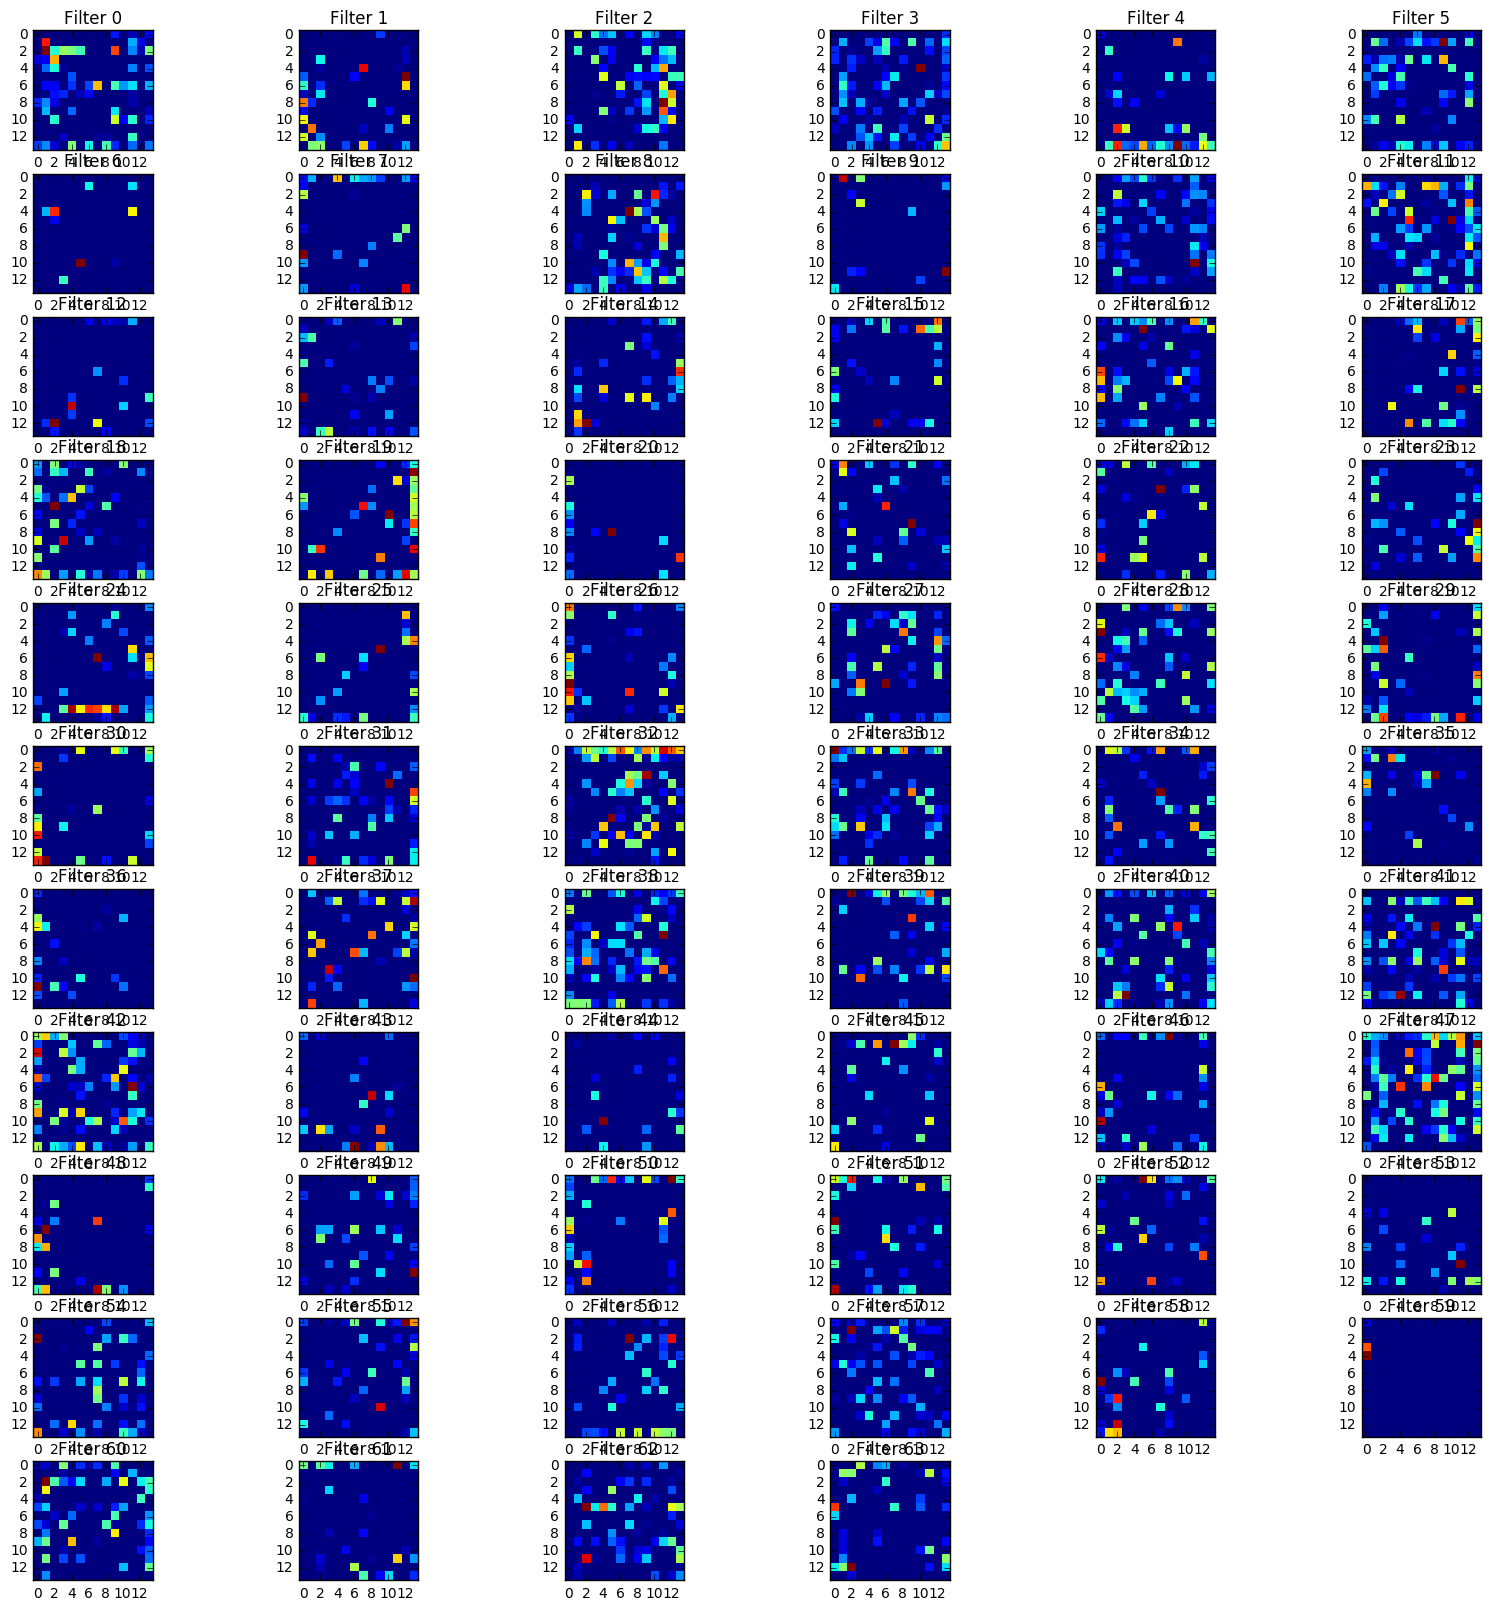

In [10]:
getActivations(h_conv2,imageToUse)